In [26]:
%matplotlib inline
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext, Row
from pyspark.sql.types import *
from pyspark.sql.functions import *
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sqlCtx = SQLContext(sc)

In [3]:
schema = StructType([
    StructField("TransactionId", IntegerType()),
    StructField("TransactionDateTime", TimestampType()),
    StructField("TransactionDate", TimestampType()),
    StructField("timeStart", StringType()),
    StructField("timeExpired", StringType()),
    StructField("Duration_mins", IntegerType()),
    StructField("Amount", DoubleType()),
    StructField("PaymentMean", StringType()),
    StructField("MeterCode", IntegerType()),
    StructField("ElementKey", IntegerType()),
])
data = sqlCtx.read.format('com.databricks.spark.csv').schema(
    schema).option('header', 'true').load('/raid/data/ParkingTransaction_20120101_20170930_cleaned.csv')
data.cache()
data.printSchema()

root
 |-- TransactionId: integer (nullable = true)
 |-- TransactionDateTime: timestamp (nullable = true)
 |-- TransactionDate: timestamp (nullable = true)
 |-- timeStart: string (nullable = true)
 |-- timeExpired: string (nullable = true)
 |-- Duration_mins: integer (nullable = true)
 |-- Amount: double (nullable = true)
 |-- PaymentMean: string (nullable = true)
 |-- MeterCode: integer (nullable = true)
 |-- ElementKey: integer (nullable = true)



In [4]:
data.count()

62327970

In [5]:
def filter_by_date(data, dates=("2012-01-01", "2012-12-31"), col='TransactionDateTime'):
    date_from, date_to = [to_date(lit(s)).cast(TimestampType()) for s in dates]
    return data.where((data[col] >= date_from) & (data[col] <= date_to))

In [6]:
def count_by_time(df, timetype='hour', col='TransactionDateTime'):
    if timetype=='hour':
        res = df.groupBy(hour(col).alias(timetype))
    elif timetype=='month':
        res = df.groupBy(month(col).alias(timetype))
    elif timetype=='dayofyear':  # daily
        res = df.groupBy(dayofyear(col).alias(timetype))
    elif timetype=='dayofweek':
        res = df.select('TransactionId', date_format(col, 'E').alias(timetype)).groupBy(timetype)
    else:
        print("unsupported", timetype)
        return None
    
    return res.agg(count(lit(1))).withColumnRenamed("count(1)", "count").orderBy(timetype)

In [7]:
dfs = {}
for year in range(2012, 2018):
    dfs[year] = {'rdd':None, 'hourly':None, 'daily':None, 'weekly':None, 'monthly':None}
    dfs[year]['rdd'] = filter_by_date(data, ('{}-01-01'.format(year), '{}-12-31'.format(year)))
    dfs[year]['rdd'].cache()
    dfs[year]['hourly'] = count_by_time(dfs[year]['rdd'], 'hour')
    dfs[year]['hourly'].cache()
    dfs[year]['daily'] = count_by_time(dfs[year]['rdd'], 'dayofyear')
    dfs[year]['daily'].cache()
    dfs[year]['weekly'] = count_by_time(dfs[year]['rdd'], 'dayofweek')
    dfs[year]['weekly'].cache()
    dfs[year]['monthly'] = count_by_time(dfs[year]['rdd'], 'month')
    dfs[year]['monthly'].cache()

In [8]:
import pandas as pd
from functools import reduce

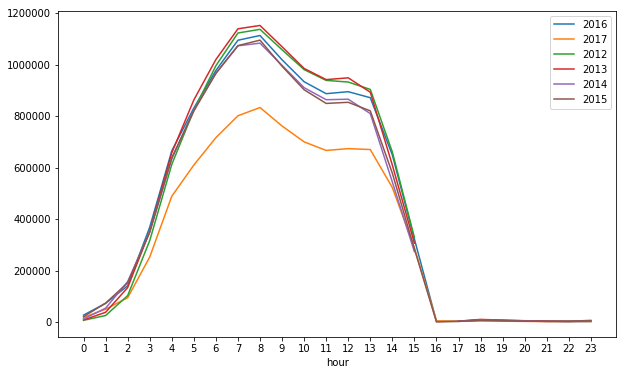

In [9]:
"""
2017
    hour   count
0      0   18273
1      1   49776
2      2   94665
3      3  252642
4      4  488726
5      5  610021
6      6  716404
7      7  801497
8      8  833492
9      9  761695
10    10  700081
11    11  666714
12    12  673818
13    13  670253
14    14  522509
15    15  288442
16    16    4322
17    17    3245
18    18    4108
19    19    3324
20    20    2471
21    21    1633
22    22    1834
23    23    4488

Usually after 4pm much less parking???
"""
hourly_df = reduce(lambda left,right: pd.merge(left,right,on='hour', how='outer'), 
                   [dfs[year]['hourly'].withColumnRenamed("count", "{}".format(year)).toPandas() for year in dfs])
hourly_df = hourly_df.set_index('hour')
hourly_df.plot(figsize=(10,6), xticks=hourly_df.index)

In [10]:
hourly_df.to_csv('hourly.csv')

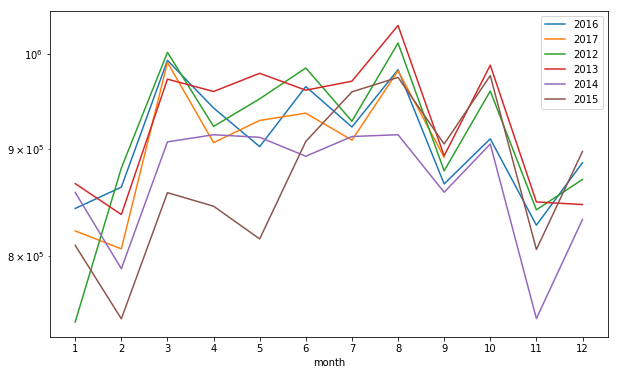

In [11]:
monthly_df = reduce(lambda left,right: pd.merge(left,right,on='month', how='outer'),  # 2017 only till September
                   [dfs[year]['monthly'].withColumnRenamed("count", "{}".format(year)).toPandas() for year in dfs])
monthly_df = monthly_df.set_index('month')
monthly_df.plot(figsize=(10,6), xticks=monthly_df.index, logy=True)

In [12]:
monthly_df.to_csv('monthly.csv')

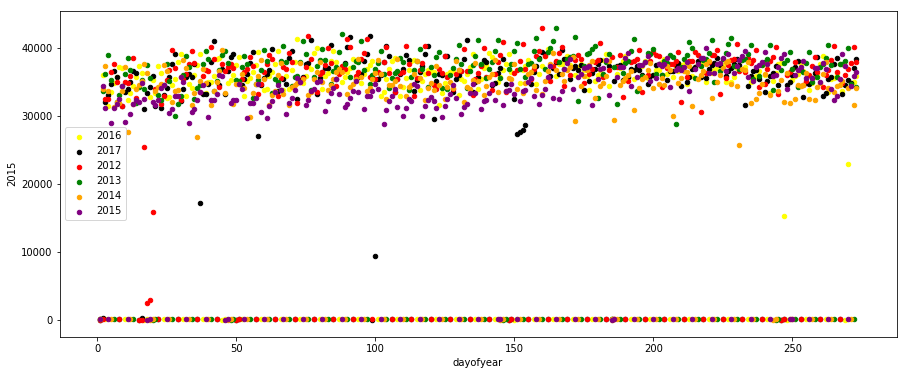

In [13]:
yearly_df = reduce(lambda left,right: pd.merge(left,right,on='dayofyear'), 
                   [dfs[year]['daily'].withColumnRenamed("count", "{}".format(year)).toPandas() for year in dfs])
color={2012:'r', 2013:'g', 2014:'orange', 2015:'purple', 2016:'yellow', 2017:'black'}
ax=None
for year in dfs.keys():
    ax=yearly_df.plot(figsize=(15,6), kind='scatter', label=year,
                      x='dayofyear', y='{}'.format(year), color=color[year], ax=ax)

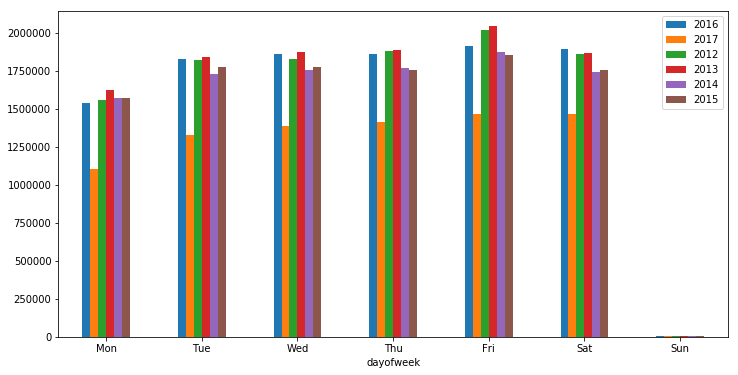

In [14]:
weekly_df = reduce(lambda left,right: pd.merge(left,right,on='dayofweek'), 
                   [dfs[year]['weekly'].withColumnRenamed("count", "{}".format(year)).toPandas() for year in dfs])
weekly_df['dayofweek']=pd.Categorical(weekly_df['dayofweek'], categories=['Mon','Tue','Wed','Thu','Fri','Sat', 'Sun'], ordered=True)
weekly_df = weekly_df.sort_values('dayofweek')  # sort by from Mon to Sun
weekly_df.set_index('dayofweek').plot.bar(rot=0, figsize=(12,6))

In [15]:
weekly_df.to_csv('weekly.csv')

In [16]:
from pyspark.sql.functions import *

In [17]:
everymin = 60 

def get_hourly(df, everymin=60):
    f = udf(lambda minutes: minutes // everymin, IntegerType())
    colname = "Duration_{}min".format(everymin)
    tmpdf = df.withColumn(colname, f(df['Duration_mins']))
    tmpdf = tmpdf.groupBy(colname, hour('TransactionDateTime').alias('hour')).agg(count("*")).withColumnRenamed("count(1)", "count")
    tmpdf = tmpdf.groupBy('hour').agg(avg(col(colname)).alias('avg')).withColumnRenamed("count(1)", "count")
    tmpdf.cache()
    return tmpdf
    
for year in range(2012, 2018):
    dfs[year]['rdd'] = dfs[year]['rdd'].filter(dfs[year]['rdd']['Duration_mins'] > 0)  # filter out 0 mins stay
    
    # group to get ['Duration_30min', 'hour(TransactionDateTime)', 'count']
    dfs[year]['hourly_{}min'.format(everymin)] = get_hourly(dfs[year]['rdd'], 60)
    
#     dfs[year]['daily_30min'] = dfs[year]['rdd'].groupBy('Duration_30min', dayofyear('TransactionDateTime')).agg(count("*")).withColumnRenamed("count(1)", "count")
#     dfs[year]['daily_30min'].cache()
    
#     dfs[year]['weekly_30min'] = dfs[year]['rdd'].select('TransactionId', 'Duration_30min', date_format('TransactionDateTime', 'E').alias('dayofweek')).groupBy('Duration_30min', 'dayofweek').agg(count("*")).withColumnRenamed("count(1)", "count")
#     dfs[year]['weekly_30min'].cache()
    
#     dfs[year]['monthly_30min'] = dfs[year]['rdd'].groupBy('Duration_30min', month('TransactionDateTime')).agg(count("*")).withColumnRenamed("count(1)", "count")
#     dfs[year]['monthly_30min'].cache()

In [18]:
dfs[year]['hourly_60min'].columns

['hour', 'avg']

In [19]:
hourly_df = reduce(lambda left,right: pd.merge(left,right,on='hour'), 
                   [dfs[year]['hourly_{}min'.format(everymin)].withColumnRenamed("avg", "{}".format(year)).toPandas() for year in dfs])

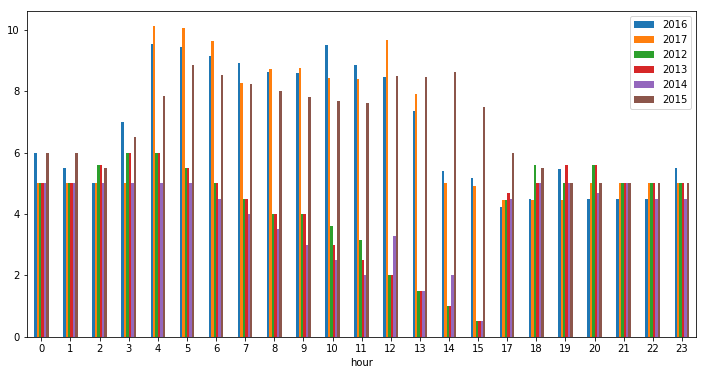

In [20]:
hourly_df = hourly_df.sort_values('hour')
hourly_df.set_index('hour').plot.bar(rot=0, figsize=(12,6))

In [21]:
def v(x, t, a=8):
    res = 0
    if x <= 0 or t == 0:
        return 0
    
    fac_i = 1
    for i in range(x):
        res += (a*t/np.e)**i / fac_i
        fac_i *= i+1  # update
    return np.log(res)

In [22]:
def p(x, t, a=8):
    return 1 + v(x, t, a) - v(x-1, t, a)

In [23]:
def r(T=24, S=24, P=25, a=8):
    XT = np.zeros([S,T]).astype(np.int)
    XT[:, :] = P
    ps = np.zeros(XT.shape)

    for i in range(10):
        for t in range(T):
            for x in range(S): # service periods
                ps[x, t] = 1 + v(XT[x,t], t, a) - v(XT[x,t]-1, t, a)
                d = a * np.exp(-ps[x,t])
                if d > XT[x, t]:
                    XT[x, t] = 0
                else:
                    XT[x, t] = P - np.ceil(d)   
        #print("iter={}, max_price={:.2f}, min_price={:.2f}, max_spots={}, min_spots={}, revenue={:.2f}".format(
        #    i, np.max(ps), np.min(ps), np.max(XT), np.min(XT), np.sum(ps * (P - XT))))
    return np.sum(ps * (P - XT))

In [24]:
def f(T=24, S=24, P=25, a=8, pr=1):
    XT = np.zeros([S,T]).astype(np.int)
    XT[:, :] = P
    ps = np.zeros(XT.shape)
    ps[:, :] = pr 

    for t in range(T):
        for x in range(S): # service periods
            d = a * np.exp(- ps[x,t])
            XT[x, t] = XT[x, t] - np.ceil(d)

    XT = P - XT
    return np.sum(ps * XT)

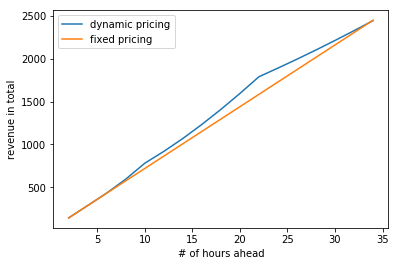

<Figure size 2160x2160 with 0 Axes>

In [29]:
TS = range(2, 36, 2)
RS = []
FS = []
for T in TS:
    RS.append(r(T=T))
    FS.append(f(T=T))
plt.plot(TS,RS,TS,FS)
plt.gca().legend(('dynamic pricing','fixed pricing'))
plt.xlabel('# of hours ahead')
plt.ylabel('revenue in total')
plt.figure(figsize=(30,30))
plt.show()